In [1]:
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas

rng = np.random.default_rng(seed=0)

In [2]:
# Population
SIZE = 150_000

BASE_CHURN = 0.16 # 16% churn means 84% retention

# ML
TEST_SIZE = 50_000 # 0.3 # 0.3 means 30% test set size


In [3]:
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)


ppl = pd.DataFrame(
    {
        "bad_exp": rng.binomial(
           1, 0.2, SIZE
        ),  # True if they had a bad experience with company
        "mkt_neg": rng.binomial(
            1, 0.2, SIZE
        ),  # True if receiving marketing will increase churn probability for them
        #"mkt_pos": rng.binomial(1, 0.2, SIZE) # True if marketing helps retain this customer
    }
)
ppl["gets_mkting"] = rng.binomial(1, 0.5, SIZE)

ppl["prob_churn"] = BASE_CHURN  # a reasonably standard churn rate
ppl.sample(5)

,bad_exp,mkt_neg,gets_mkting,prob_churn
43871,0,0,0,0.16
125774,0,0,0,0.16
95791,0,0,0,0.16
28465,0,0,1,0.16
57726,1,0,1,0.16


In [4]:
# people who like marketing and who get marketing have a lower chance of churning
if False:
    mask = (ppl["mkt_pos"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask, "prob_churn"] -= 0.1  # TODO HUGE BIAS

    assert (
        mask.sum() / mask.shape[0] < 0.2
    ), "Not expecting a high rate of churn even with random variation"

    display(ppl[mask].sample(5))

In [5]:
# people who hate marketing and who get marketing have a higher chance of churning
mask = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
ppl.loc[mask, "prob_churn"] += 0.5  # TODO HUGE BIAS

assert (
    mask.sum() / mask.shape[0] < 0.2
), "Not expecting a high rate of churn even with random variation"

ppl[mask].sample(5)

,bad_exp,mkt_neg,gets_mkting,prob_churn
145681,0,1,1,0.66
70339,0,1,1,0.66
50669,0,1,1,0.66
125208,0,1,1,0.66
13775,0,1,1,0.66


In [6]:
# people who have had a negative experience have a higher chance of churn
mask = ppl['bad_exp'] == 1
ppl.loc[mask, 'prob_churn'] += 0.1
ppl[mask].sample(5)

,bad_exp,mkt_neg,gets_mkting,prob_churn
119969,1,0,1,0.26
17186,1,0,1,0.26
17419,1,0,0,0.26
42403,1,1,0,0.26
29103,1,0,0,0.26


In [7]:
ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])

In [8]:
ppl['prob_churn_bin'] = pd.cut(ppl['prob_churn'], bins=10)
display(ppl.groupby('prob_churn_bin')['will_churn'].sum())
display(ppl.groupby('prob_churn_bin')['will_churn'].sum() / ppl.groupby('prob_churn_bin')['will_churn'].size())
ppl = ppl.drop(columns='prob_churn_bin')

prob_churn_bin
(0.159, 0.22]    17230
(0.22, 0.28]      7040
(0.28, 0.34]         0
(0.34, 0.4]          0
(0.4, 0.46]          0
(0.46, 0.52]         0
(0.52, 0.58]         0
(0.58, 0.64]         0
(0.64, 0.7]       7975
(0.7, 0.76]       2216
Name: will_churn, dtype: int64

prob_churn_bin
(0.159, 0.22]    0.159233
(0.22, 0.28]     0.263178
(0.28, 0.34]          NaN
(0.34, 0.4]           NaN
(0.4, 0.46]           NaN
(0.46, 0.52]          NaN
(0.52, 0.58]          NaN
(0.58, 0.64]          NaN
(0.64, 0.7]      0.657895
(0.7, 0.76]      0.758385
Name: will_churn, dtype: float64

In [9]:
ppl.head()

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,0,1,0.16,0
1,0,0,1,0.16,1
2,0,0,0,0.16,0
3,0,0,0,0.16,0
4,1,0,0,0.26,0


In [10]:
ppl.describe()

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.197813,0.199720,0.500753,0.229928,0.229740
std,0.398352,0.399791,0.500001,0.155273,0.420667
min,0.000000,0.000000,0.000000,0.160000,0.000000
25%,0.000000,0.000000,0.000000,0.160000,0.000000
50%,0.000000,0.000000,1.000000,0.160000,0.000000
75%,0.000000,0.000000,1.000000,0.260000,0.000000
max,1.000000,1.000000,1.000000,0.760000,1.000000


In [11]:
ppl

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,0,1,0.16,0
1,0,0,1,0.16,1
2,0,0,0,0.16,0
3,0,0,0,0.16,0
4,1,0,0,0.26,0
...,...,...,...,...,...
149995,1,0,0,0.26,1
149996,0,0,1,0.16,0
149997,0,0,1,0.16,0
149998,0,0,0,0.16,0


In [12]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        #"mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(int, [pa.Check.isin([0, 1]), pa.Check(lambda s: s.mean() > 0.45), pa.Check(lambda s: s.mean() < 0.55)]),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                pa.Hypothesis.two_sample_ttest(
                    sample1=1,
                    sample2=0,
                    groupby="mkt_neg",
                    relationship="greater_than",
                    alpha=0.05,
                    equal_var=True,
                ),
            ],
        ),
    }, strict=True, ordered=False
)
schema.validate(ppl, lazy=True, );

# Look at some examples of those who do or don't churn

In [13]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
10,1,0,1,0.26,1
16,1,1,1,0.76,1


In [14]:
ppl.query("will_churn==True and prob_churn == @BASE_CHURN")[:2]

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
1,0,0,1,0.16,1
6,0,0,1,0.16,1


In [15]:
ppl.query("will_churn==False")[:2]

,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
0,0,0,1,0.16,0
2,0,0,0,0.16,0


# Start to prepare for ML

In [16]:
ppl.columns

Index(['bad_exp', 'mkt_neg', 'gets_mkting', 'prob_churn', 'will_churn'], dtype='object')

In [17]:
features = ["mkt_neg", 'bad_exp']
#, 'mkt_pos']
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = set(ppl.columns).difference(set(features)).difference({'will_churn', 'prob_churn', 'gets_mkting'})

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1/0 # we shouldn't get here

Using: ['mkt_neg', 'bad_exp']


In [18]:
ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
)
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 5), (50000, 5), (100000, 2), (50000, 2), (100000,), (50000,)]


In [19]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.5380927780174926

In [20]:
base_model = LogisticRegression

In [21]:
churn_model = base_model
#churn_model = LogisticRegression
#churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

Fitting churn model with <class 'sklearn.linear_model._logistic.LogisticRegression'>


0.5084194948157862

## Start to prepare for dual fit

In [22]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
uplift_model = base_model
#uplift_model = LogisticRegression
#uplift_model = partial(RandomForestClassifier, n_estimators=10)
est_up_c = uplift_model()
est_up_t = uplift_model()

print(f"Building a C and T model with {est_up_c} and {est_up_t}")

mask_train_c = ppl_train["gets_mkting"] == 0
mask_train_t = ppl_train["gets_mkting"] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

# score on their sub-trained population type
mask_test_c = ppl_test["gets_mkting"] == 0
mask_test_t = ppl_test["gets_mkting"] == 1
up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]

print(log_loss(y_test[mask_test_c], up_c_pred_proba_pos))
print(
    log_loss(y_test[mask_test_t], up_t_pred_proba_pos)
)  # CHECK expect lower than control

Building a C and T model with LogisticRegression() and LogisticRegression()
0.46964307590655896
0.4931459452108347


## Check C and T predictions from Uplift model

In [23]:
pd.Series(up_c_pred_proba_pos).describe()

count    24995.000000
mean         0.179785
std          0.041098
min          0.157140
25%          0.157140
50%          0.157140
75%          0.169537
max          0.276276
dtype: float64

In [24]:
pd.Series(up_t_pred_proba_pos).describe()

count    25005.000000
mean         0.280190
std          0.203749
min          0.160726
25%          0.160726
50%          0.160726
75%          0.258926
max          0.776288
dtype: float64

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [25]:
if False:
    # incorrect for uplift! # WRONG
    result = pd.DataFrame({"churn_proba_pos": y_pred_proba_pos, "y_true": y_test})
    result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]

    result["uplift_proba_pos"] = -1
    result.loc[mask_test_t, "uplift_proba_pos"] = up_t_pred_proba_pos
    result.loc[mask_test_c, "uplift_proba_pos"] = up_c_pred_proba_pos
    assert (result['uplift_proba_pos'] == -1).sum() == 0, "No entries for -1 expected"

    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
    keys = ["uplift_proba_pos", "churn_proba_pos", "dummy_proba_pos"]
    for key in keys:
        result_sorted = result.sort_values(key, ascending=False).reset_index()
        result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
        result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key)
    ax.set_ylabel("True Positives (faster climb better)")
    ax.set_xlabel("Test population");

    set_common_mpl_styles(ax, grid_axis="both")
    #set_commas(ax, True, True)

    #ax.set_xlim((10_000, result.shape[0]-1)); # zoom on x axis

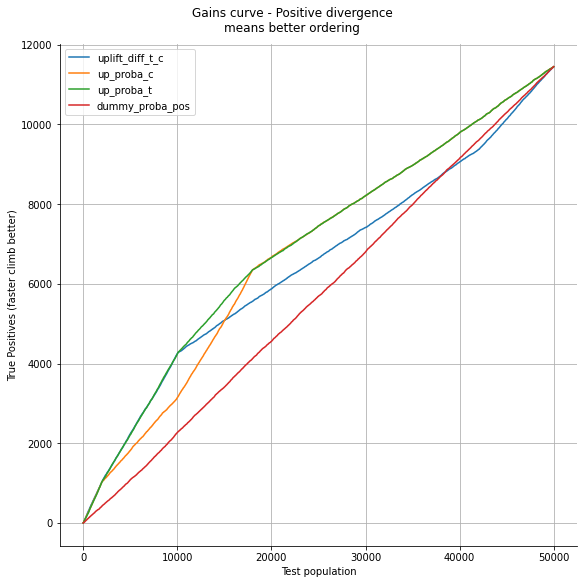

In [26]:
# incorrect for uplift!
result = pd.DataFrame({"y_true": y_test})

result["churn_proba_pos"] = est_churn.predict_proba(X_test)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]


result['up_proba_c'] = est_up_c.predict_proba(X_test)[:, 1]
result['up_proba_t'] = est_up_t.predict_proba(X_test)[:, 1]
# if T says 90% prob churn conditional mkting, C says 10% prob churn then +80%
# if T says 10% prob churn conditional mkting, C says 90% prob churn then -80%
result['uplift_diff_t_c'] = result['up_proba_t'] - result['up_proba_c']
#result['uplift_diff_t_c'] = result['up_proba_c'] - result['up_proba_t']

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
#key = 'uplift_diff_t_c'
#keys = ['uplift_diff_t_c', 'churn_proba_pos', 'dummy_proba_pos']
keys = ['uplift_diff_t_c', 'up_proba_c', 'up_proba_t', 'dummy_proba_pos']#, 'churn_proba_pos']
for key in keys:
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key)
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Test population");

set_common_mpl_styles(ax, grid_axis="both")
#set_commas(ax, True, True)

#ax.set_xlim((10_000, result.shape[0]-1)); # zoom on x axis

<AxesSubplot:>

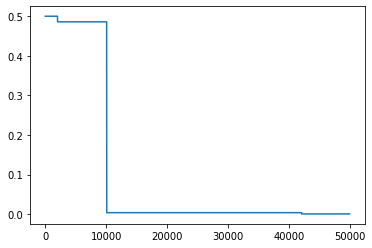

In [27]:
# sort by predicted uplift, the earliest values have lowest chance of churn if marketed at or are sure things,
# the last values have highest chance of churn if marketed at (sleeping dogs) or are lost causes
result.sort_values('uplift_diff_t_c', ascending=False)['uplift_diff_t_c'].reset_index(drop=True).plot()

In [28]:
test_merged = pd.merge(left=result, right=ppl_test, left_index=True, right_index=True, validate="one_to_one")
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values('prob_churn')

,y_true,churn_proba_pos,dummy_proba_pos,up_proba_c,up_proba_t,uplift_diff_t_c,bad_exp,mkt_neg,gets_mkting,prob_churn,will_churn
16610,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,1,0.16,0
37587,1,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,1,0.16,1
115188,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,0,0.16,0
1939,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,0,0.16,0
149023,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,0,0.16,0
31285,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,0,0.16,0
62527,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,1,0.16,0
36026,0,0.160387,0.2301,0.157140,0.160726,0.003586,0,0,1,0.16,0
35328,0,0.252774,0.2301,0.258504,0.258926,0.000422,1,0,0,0.26,0
51001,1,0.551367,0.2301,0.276276,0.776288,0.500012,1,1,1,0.76,1


In [54]:
#test_merged_sorted = test_merged.sort_values('uplift_diff_t_c', ascending=False)
test_merged['uplift_diff_t_c_bins'] = pd.cut(test_merged['uplift_diff_t_c'], 5)
#test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 2)
#test_merged.groupby('bins')[['mkt_neg', 'bad_exp']].sum()

In [55]:
features

['mkt_neg', 'bad_exp']

In [56]:
# with 50k test we have 10k per group
test_merged.groupby('uplift_diff_t_c_bins').agg(mkt_neg_sum=pd.NamedAgg('mkt_neg', 'sum'),
                               bad_exp_sum=pd.NamedAgg('bad_exp', 'sum'),
                               up_proba_c_mean=pd.NamedAgg('up_proba_c', 'mean'),
                               up_proba_t_mean=pd.NamedAgg('up_proba_t', 'mean'),
                                               count=pd.NamedAgg('mkt_neg', 'size'))

,mkt_neg_sum,bad_exp_sum,up_proba_c_mean,up_proba_t_mean,count
uplift_diff_t_c_bins,,,,,
"(-7.8e-05, 0.1]",0,7912,0.177230,0.180189,39920
"(0.1, 0.2]",0,0,NaN,NaN,0
"(0.2, 0.3]",0,0,NaN,NaN,0
"(0.3, 0.4]",0,0,NaN,NaN,0
"(0.4, 0.5]",10080,2001,0.190726,0.679402,10080


In [33]:
#test_merged_sorted = test_merged.sort_values('uplift_diff_t_c', ascending=False)
#test_merged_sorted['bins'] = pd.cut(test_merged_sorted.index, 10)
#test_merged_sorted.groupby('bins')[['mkt_neg', 'bad_exp']].sum()